In [56]:
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from torchvision import transforms, datasets

In [74]:
traindatanp = np.loadtxt("./cifar/dogs.csv",delimiter=',').reshape(5000,3,32,32)
traindatanp = traindatanp.astype('float32')
traindata = (torch.from_numpy(traindatanp)-128) / 128


In [75]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [76]:
class Generative(nn.Module):
    def __init__(self):
        super(Generative, self).__init__()
        
        self.main = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                # state size. 256 x 4 x 4
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                # state size. 128 x 8 x 8
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                # state size. 64 x 16 x 16
                nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
                nn.Tanh()
                # state size. 3 x 32 x 32
            )
    
    def forward(self, x):
        return self.main(x)
    

In [77]:
class Discriminative(nn.Module):
    def __init__(self):
        super(Discriminative, self).__init__()
        
        self.main = nn.Sequential(
                # input is 3 x 32 x 32
                nn.Conv2d(3, 32, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 32 x 32 x 32
                nn.Conv2d(32, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 64 x 16 x 16
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 128 x 8 x 8
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 256 x 4 x 4
                nn.Conv2d(256, 1, 2, 1, 0, bias=False),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        return self.main(x)

In [78]:
lr = 0.0002

device=torch.device("cuda:0")

disc = Discriminative()
disc.apply(weights_init)
disc.cuda()
disc_optimizer = optim.Adam(params=disc.parameters(), lr=lr, betas=(0.5,0.999))

loss = nn.BCELoss()

gen = Generative()
gen.apply(weights_init)
gen.cuda()
gen_optimizer = optim.Adam(params=gen.parameters(), lr=lr, betas=(0.5,0.999))

n_epochs = 100


for e in range(n_epochs):
    for i in range(50):
        
        real_images = traindata[(i*100):(i+1)*100].to(device)
        
        disc_optimizer.zero_grad()

        # Define real_images, real_labels
        real_labels = torch.full((real_images.size(0),1), 1).view(100).to(device)
        # Generate noise and define fake_labels
        noise_vectors = torch.randn(real_images.size(0), 100, 1, 1).to(device)
        fake_labels = torch.full((real_images.size(0),1), 0).view(100).to(device)

        # Train discriminative network one step using batch of real images
        #real_images = real_images + (torch.randn(real_images.size())/10)
        output = disc(real_images).view(100)
        real_loss = loss(output, real_labels)
        real_loss.backward()
        disc_real_avg = output.mean().item()

        # Generate fake images from noise and pass them through disc. net.
        fake_images = gen(noise_vectors)
        #fake_images = fake_images + (torch.randn(fake_images.size())/10)
        output = disc(fake_images.detach()).view(100)
        fake_loss = loss(output, fake_labels)
        fake_loss.backward()

        # Aggregative real and fake loss and update weights
        step_loss = real_loss + fake_loss
        disc_fake_avg = output.mean().item()
        disc_optimizer.step()

        # Train generative network
        gen_optimizer.zero_grad()

        output = disc(fake_images).view(100)
        gen_loss = loss(output, real_labels)
        gen_loss.backward()
        gen_avg = output.mean().item()
        gen_optimizer.step()

        if i % 50 == 49:
            print("Epoch: "+str(e+1)+" | Disc. Loss: "+str(step_loss.item())+" | Gen. Loss: "+str(gen_loss.item())+
             " | D(X): "+str(disc_real_avg)+" | D(G(Z)): "+str(disc_fake_avg)+" -> "+str(gen_avg))
            


Epoch: 1 | Disc. Loss: 0.47906380891799927 | Gen. Loss: 3.6353371143341064 | D(X): 0.8099265694618225 | D(G(Z)): 0.2148907482624054 -> 0.03205327317118645
Epoch: 2 | Disc. Loss: 0.773972749710083 | Gen. Loss: 2.366635799407959 | D(X): 0.6553178429603577 | D(G(Z)): 0.24293597042560577 -> 0.10677433758974075
Epoch: 3 | Disc. Loss: 1.0001342296600342 | Gen. Loss: 2.3660659790039062 | D(X): 0.5634182095527649 | D(G(Z)): 0.26532575488090515 -> 0.10991876572370529
Epoch: 4 | Disc. Loss: 1.3581700325012207 | Gen. Loss: 3.002457857131958 | D(X): 0.4930838644504547 | D(G(Z)): 0.3389478921890259 -> 0.07360955327749252
Epoch: 5 | Disc. Loss: 0.9298191070556641 | Gen. Loss: 2.750962018966675 | D(X): 0.7022242546081543 | D(G(Z)): 0.3884325623512268 -> 0.08349984884262085
Epoch: 6 | Disc. Loss: 0.5263035893440247 | Gen. Loss: 2.926800489425659 | D(X): 0.8325860500335693 | D(G(Z)): 0.2700273394584656 -> 0.06617031246423721
Epoch: 7 | Disc. Loss: 0.4762887954711914 | Gen. Loss: 4.132657527923584 | D(X

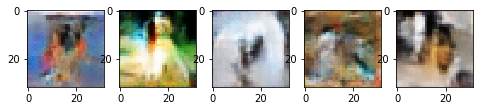

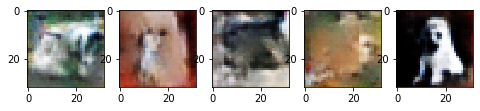

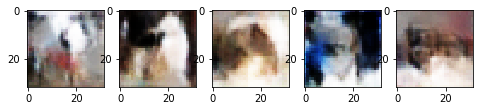

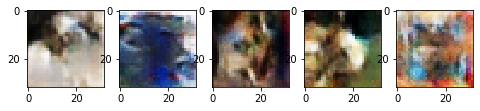

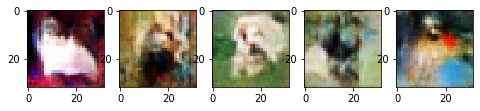

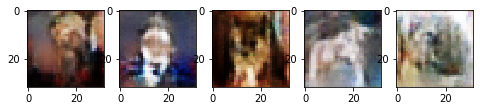

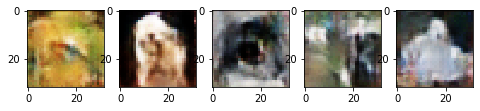

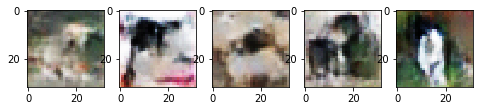

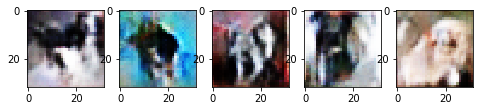

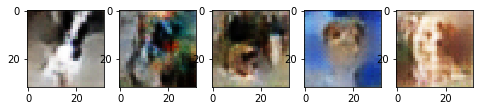

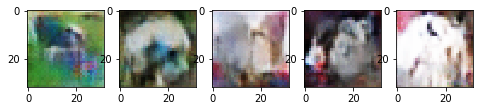

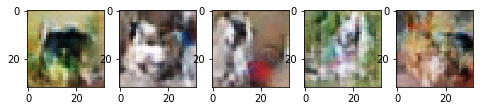

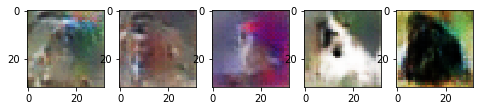

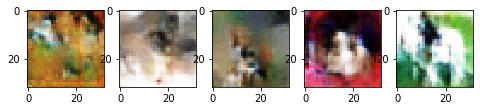

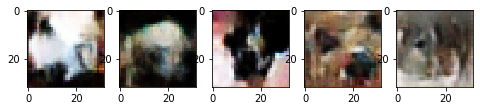

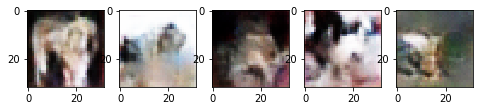

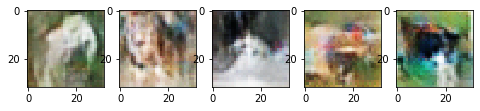

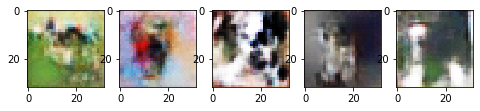

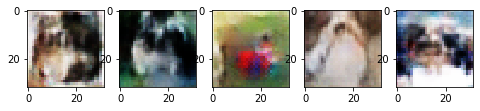

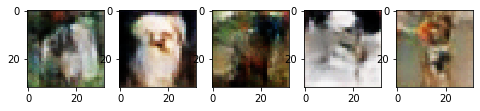

In [81]:
noise_vectors = torch.randn(real_images.size(0), 100, 1, 1).to(device)
fake_images = gen(noise_vectors)

fake_images.shape

for k in range(20):
    fig, axes = plt.subplots(1,5,figsize=(8,8))
    for j, im in enumerate(axes.flat):
        im.imshow((fake_images[5*k+j].detach().cpu().numpy().transpose(1,2,0)+1)/2)